<a href="https://colab.research.google.com/github/AkashXII/DeepReef-Ai/blob/main/reef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/healthy-and-bleached-corals-image-classification")

print("Path to dataset files:", path)

100%|██████████| 25.8M/25.8M [00:00<00:00, 193MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification/versions/1


Found 923 files belonging to 2 classes.
Using 739 files for training.
Found 923 files belonging to 2 classes.
Using 184 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4429 - loss: 0.8240 - val_accuracy: 0.4022 - val_loss: 0.7483
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5176 - loss: 0.7519 - val_accuracy: 0.5924 - val_loss: 0.6810
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5967 - loss: 0.6843 - val_accuracy: 0.4946 - val_loss: 0.7315
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5522 - loss: 0.7088 - val_accuracy: 0.6522 - val_loss: 0.6603
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6183 - loss: 0.6732 - val_accuracy: 0.6196 - val_loss: 0.6811
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6456 - loss: 0.6484 - val_accuracy: 0.6522 - val_loss: 0.6408
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - a

✅ Model saved as coral_bleaching_model_improved.h5


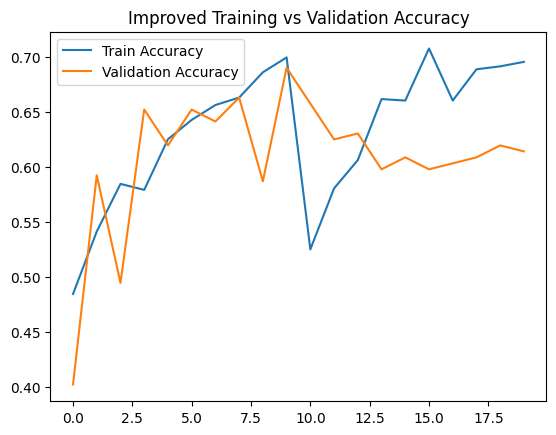

In [7]:
# STEP 1: Import Libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

# STEP 2: Define dataset path
data_dir = "/root/.cache/kagglehub/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification/versions/1"

# STEP 3: Load dataset with higher resolution and validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(224,224),  # higher resolution for better detail
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(224,224),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)

# STEP 4: Data augmentation (to improve generalization)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

# STEP 5: Optimize dataset loading
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# STEP 6: Build the base model using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base initially

# STEP 7: Build the model architecture
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),  # helps prevent overfitting
    layers.Dense(1, activation='sigmoid')
])

# STEP 8: Compile and train (Stage 1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# STEP 9: Fine-tune last layers for better accuracy
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # unfreeze only last 30 layers

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# STEP 10: Save the model
model.save("coral_bleaching_model_improved.h5")
print("✅ Model saved as coral_bleaching_model_improved.h5")

# STEP 11: Plot training vs validation accuracy
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Improved Training vs Validation Accuracy")
plt.legend()
plt.show()
